In [16]:
import os 
import sys

import pandas as pd
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt
import IPython.display as ipd

from scipy.io import wavfile as wav
from sklearn import metrics 
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split 
import tensorflow as tf
# from keras.models import Sequential
# from keras.layers import Dense, Dropout, Activation
# from keras.optimizers import Adam
from sklearn.linear_model import LogisticRegression

%matplotlib inline
%config InlineBackend.figure_format='retina'

ImportError: cannot import name 'to_categorical' from 'keras.utils' (/Users/harshinderchadha/general/lib/python3.8/site-packages/keras/utils/__init__.py)

In [4]:
PATH = os.getcwd() + '/speech_commands_v0.01/'

In [6]:
def get_directory_contents(path):
    return os.listdir(path)

def open_file(filename):
    
    f = open(filename)
    return f.read().splitlines()

def compile_dataset(folders):
    
    total_words = []
    for folder in folders:
        words = get_directory_contents(path=PATH+folder)
        words = [folder+'/'+word for word in words]
        total_words = total_words + words
    
    dataset = create_df(words=total_words)
                           
    return dataset

def create_df(words):
    
    data = pd.DataFrame({'recordings':words})

    data['word'] = data['recordings'].str.split('/').str[0]
    data['speaker_id'] = data['recordings'].str.split('/').str[1]
    data['speaker_id'] =data['speaker_id'].str.split('_').str[0]
    
    return data

def summary(data):
    
    summary_df = pd.DataFrame()
    summary_df['total_recordings'] = [data.shape[0]]
    summary_df['total_speakers'] = len(data['speaker_id'].unique())
    summary_df['total_words'] = len(data['word'].unique())
    
    return summary_df

def word_distribution():
    
    word_count = data['word'].value_counts()
    ax = word_count.plot(kind='bar', figsize=(8,4), alpha=0.5)
    plt.show()

In [7]:
remove_words = [
    '.DS_Store', 'validation_list.txt', 'LICENSE',
    '_background_noise_', 'README.md', 'testing_list.txt'
]

names = get_directory_contents(path=PATH)
names = [word for word in names if word not in remove_words]

In [8]:
val_list = open_file(filename=PATH+'validation_list.txt')
val_df = create_df(words=val_list)
test_list = open_file(filename=PATH+'testing_list.txt')
test_df = create_df(words=test_list)
total_df = compile_dataset(folders=names)

training_df = total_df[~total_df['recordings'].isin(val_df['recordings'])]
training_df = training_df[~training_df['recordings'].isin(test_df['recordings'])]

In [9]:
fn = 'speech_commands_v0.01/four/10c6d873_nohash_0.wav'
librosa_audio, librosa_sample_rate = librosa.load(fn)
scipy_sample_rate, scipy_audio = wav.read(fn)
print("Original sample rate: {}".format(scipy_sample_rate))
print("Librosa sample rate: {}".format(librosa_sample_rate))

Original sample rate: 16000
Librosa sample rate: 22050


In [10]:
print('Original audio file min~max range: {} to {}'.format(np.min(scipy_audio), np.max(scipy_audio)))
print('Librosa audio file min~max range: {0:.2f} to {0:.2f}'.format(np.min(librosa_audio), np.max(librosa_audio)))

Original audio file min~max range: -32768 to 16883
Librosa audio file min~max range: -1.00 to -1.00


In [11]:
mfccs = librosa.feature.mfcc(y=librosa_audio, sr=librosa_sample_rate, n_mfcc=40)

In [12]:
def extract_features(file_name):
    audio, sample_rate = librosa.load(file_name) 
    mfccs = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
    mfccs_processed = np.mean(mfccs.T,axis=0)
     
    return mfccs_processed

In [13]:
def dataset_prep(df):
    features = []
    # Iterate through each sound file and extract the features 
    for index, row in df.iterrows():
        file_name = 'speech_commands_v0.01/'+row['recordings']
        class_label = row["word"]
        data = extract_features(file_name)

        features.append([data, class_label])
    # Convert into a Panda dataframe 
    featuresdf = pd.DataFrame(features, columns=['feature','class_label'])
    return featuresdf

In [14]:
featuresdf = dataset_prep(df=training_df)
featuresdf.to_csv("training_set.csv")

testdf = dataset_prep(df=test_df)
valdf = dataset_prep(df=val_df)

In [15]:
testdf.to_csv("testdf.csv")
valdf.to_csv("validation_set.csv")

In [17]:
# Convert features and corresponding classification labels into numpy arrays
X = np.array(featuresdf.feature.tolist())
y = np.array(featuresdf.class_label.tolist())
# Encode the classification labels
le = LabelEncoder()
yy = tf.keras.utils.to_categorical(le.fit_transform(y))

x_val = np.array(valdf.feature.tolist())
y_val = np.array(valdf.class_label.tolist())
y_val = tf.keras.utils.to_categorical(le.transform(y_val))

x_test = np.array(testdf.feature.tolist())
y_test = np.array(testdf.class_label.tolist())
y_test = tf.keras.utils.to_categorical(le.transform(y_test))

### Normal Logistic Regression model

In [32]:
clf = LogisticRegression(multi_class='multinomial', solver='newton-cg')

In [34]:
def to_category(columns, dataframe):
    """Convert a list of columns, from a dataframe, to a category datatype"""
    for column in columns: 
        dataframe[column] = dataframe[column].astype('category')
    return dataframe
columns=['word']

training_df = to_category(columns=columns, dataframe=training_df)
test_df = to_category(columns=columns, dataframe=test_df)
val_df = to_category(columns=columns, dataframe=val_df)

In [35]:
clf.fit(X, training_df['word'])

print("Training Accuracy: {0:.2%}".format(clf.score(X, training_df['word'])))
print("Validation Accuracy: {0:.2%}".format(clf.score(x_val, val_df['word'])))
print("Testing Accuracy: {0:.2%}".format(clf.score(x_test, test_df['word'])))

Training Accuracy: 29.40%
Validation Accuracy: 29.07%
Testing Accuracy: 26.53%


/Users/harshinderchadha/general/lib/python3.8/site-packages/sklearn/utils/optimize.py:202: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn("newton-cg failed to converge. Increase the "


## Deep Learning Models 

In [156]:
def build_model_graph(input_shape=(40,)):
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Input(input_shape))
    model.add(tf.keras.layers.Dense(30))
    # Compile the model
    model.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True), 
                  metrics=['accuracy'], optimizer='adam')
    return model

def deep_nn_model(input_shape=(40,)):
    model = tf.keras.Sequential([
        tf.keras.layers.Input(input_shape),
        tf.keras.layers.Dense(36, activation='relu'),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dense(30)
    ])
    # Compile the model
    model.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
                  metrics=['accuracy'], optimizer='adam')
    return model

def big_nn_model(input_shape=(40,)):
    model = tf.keras.Sequential([
        tf.keras.layers.Input(input_shape),
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.Dense(256, activation='relu'),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(30)
    ])
    # Compile the model
    model.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True), 
                  metrics=['accuracy'], optimizer='adam')
    return model

def fit_model(model, epochs, X, y, validation_data, verbose):
    
    history, model.fit(X, y, epochs=epochs, validation_data=validation_data, verbose=verbose)
    return model, history

def plot_metric(history, metric):
    train_metrics = history.history[metric]
    val_metrics = history.history['val_'+metric]
    epochs = range(1, len(train_metrics) + 1)
    plt.plot(epochs, train_metrics)
    plt.plot(epochs, val_metrics)
    plt.title('Training and validation '+ metric)
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend(["train_"+metric, 'val_'+metric])
    plt.show()

### Vanilla Deep learning model 

In [157]:
simple_nn = build_model_graph()
simple_nn, simple_nn_history = fit_model(model=simple_nn, X=X, y=yy,
                                         epochs=100, validation_data=(x_val, y_val), verbose=1)

Epoch 1/100
1597/1597 [==============================] - 3s 1ms/step - loss: 12.7209 - accuracy: 0.1272 - val_loss: 2.9716 - val_accuracy: 0.1993
Epoch 2/100
1597/1597 [==============================] - 2s 1ms/step - loss: 2.7555 - accuracy: 0.2277 - val_loss: 2.6818 - val_accuracy: 0.2348
Epoch 3/100
1597/1597 [==============================] - 2s 1ms/step - loss: 2.6872 - accuracy: 0.2325 - val_loss: 2.7025 - val_accuracy: 0.2396
Epoch 4/100
1597/1597 [==============================] - 2s 1ms/step - loss: 2.6923 - accuracy: 0.2300 - val_loss: 2.6442 - val_accuracy: 0.2385
Epoch 5/100
1597/1597 [==============================] - 2s 1ms/step - loss: 2.6929 - accuracy: 0.2323 - val_loss: 2.6580 - val_accuracy: 0.2382
Epoch 6/100
1597/1597 [==============================] - 2s 1ms/step - loss: 2.6810 - accuracy: 0.2349 - val_loss: 2.6562 - val_accuracy: 0.2348
Epoch 7/100
1597/1597 [==============================] - 2s 2ms/step - loss: 2.6827 - accuracy: 0.2348 - val_loss: 2.6769 - val_a

1597/1597 [==============================] - 2s 1ms/step - loss: 2.6653 - accuracy: 0.2398 - val_loss: 2.6621 - val_accuracy: 0.2495
Epoch 58/100
1597/1597 [==============================] - 2s 1ms/step - loss: 2.6632 - accuracy: 0.2396 - val_loss: 2.6952 - val_accuracy: 0.2387
Epoch 59/100
1597/1597 [==============================] - 2s 1ms/step - loss: 2.6674 - accuracy: 0.2384 - val_loss: 2.7956 - val_accuracy: 0.2073
Epoch 60/100
1597/1597 [==============================] - 2s 2ms/step - loss: 2.6641 - accuracy: 0.2398 - val_loss: 2.6937 - val_accuracy: 0.2383
Epoch 61/100
1597/1597 [==============================] - 3s 2ms/step - loss: 2.6647 - accuracy: 0.2390 - val_loss: 2.6159 - val_accuracy: 0.2502
Epoch 62/100
1597/1597 [==============================] - 3s 2ms/step - loss: 2.6638 - accuracy: 0.2388 - val_loss: 2.6574 - val_accuracy: 0.2404
Epoch 63/100
1597/1597 [==============================] - 3s 2ms/step - loss: 2.6632 - accuracy: 0.2387 - val_loss: 2.6437 - val_accuracy

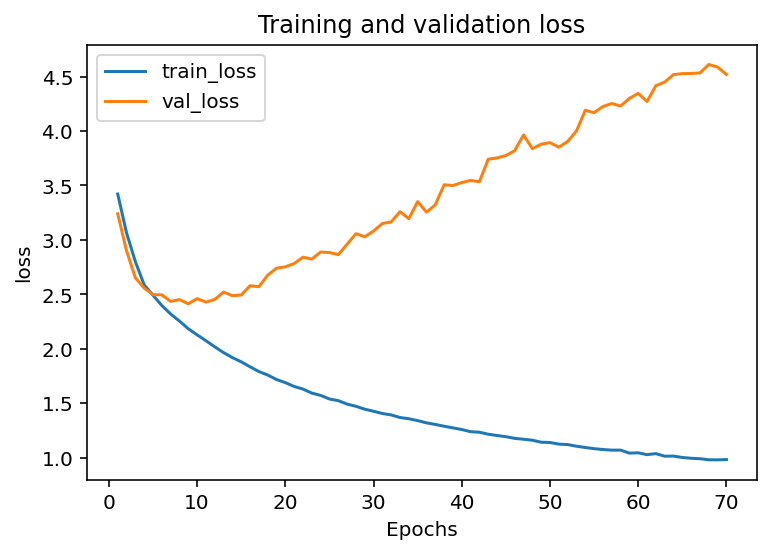

In [158]:
plot_metric(history=simple_nn_history, metric='loss')

In [159]:
score = simple_nn.evaluate(x_test, y_test, verbose=0)
print("Testing Accuracy: {0:.2%}".format(score[1]))

Testing Accuracy: 20.91%


### Deep NN model

In [160]:
deep_nn = deep_nn_model()
deep_nn, deep_nn_history = fit_model(model=simple_nn, X=X, y=yy,
                                         epochs=70, validation_data=(x_val, y_val), verbose=1)

Epoch 1/70
1597/1597 [==============================] - 3s 2ms/step - loss: 2.6587 - accuracy: 0.2390 - val_loss: 2.5759 - val_accuracy: 0.2504
Epoch 2/70
1597/1597 [==============================] - 3s 2ms/step - loss: 2.6597 - accuracy: 0.2422 - val_loss: 2.6159 - val_accuracy: 0.2437
Epoch 3/70
1597/1597 [==============================] - 3s 2ms/step - loss: 2.6603 - accuracy: 0.2399 - val_loss: 2.6724 - val_accuracy: 0.2360
Epoch 4/70
1597/1597 [==============================] - 3s 2ms/step - loss: 2.6635 - accuracy: 0.2400 - val_loss: 2.5987 - val_accuracy: 0.2439
Epoch 5/70
1597/1597 [==============================] - 3s 2ms/step - loss: 2.6548 - accuracy: 0.2395 - val_loss: 2.5733 - val_accuracy: 0.2582
Epoch 6/70
1597/1597 [==============================] - 3s 2ms/step - loss: 2.6617 - accuracy: 0.2385 - val_loss: 2.6397 - val_accuracy: 0.2404
Epoch 7/70
1597/1597 [==============================] - 2s 2ms/step - loss: 2.6656 - accuracy: 0.2362 - val_loss: 2.6459 - val_accuracy:

1597/1597 [==============================] - 3s 2ms/step - loss: 2.6653 - accuracy: 0.2363 - val_loss: 2.7510 - val_accuracy: 0.2245
Epoch 58/70
1597/1597 [==============================] - 3s 2ms/step - loss: 2.6577 - accuracy: 0.2426 - val_loss: 2.6033 - val_accuracy: 0.2476
Epoch 59/70
1597/1597 [==============================] - 3s 2ms/step - loss: 2.6543 - accuracy: 0.2405 - val_loss: 2.5927 - val_accuracy: 0.2563
Epoch 60/70
1597/1597 [==============================] - 3s 2ms/step - loss: 2.6635 - accuracy: 0.2416 - val_loss: 2.6135 - val_accuracy: 0.2586
Epoch 61/70
1597/1597 [==============================] - 3s 2ms/step - loss: 2.6583 - accuracy: 0.2418 - val_loss: 2.6480 - val_accuracy: 0.2482
Epoch 62/70
1597/1597 [==============================] - 3s 2ms/step - loss: 2.6583 - accuracy: 0.2400 - val_loss: 2.6438 - val_accuracy: 0.2358
Epoch 63/70
1597/1597 [==============================] - 3s 2ms/step - loss: 2.6588 - accuracy: 0.2395 - val_loss: 2.6028 - val_accuracy: 0.25

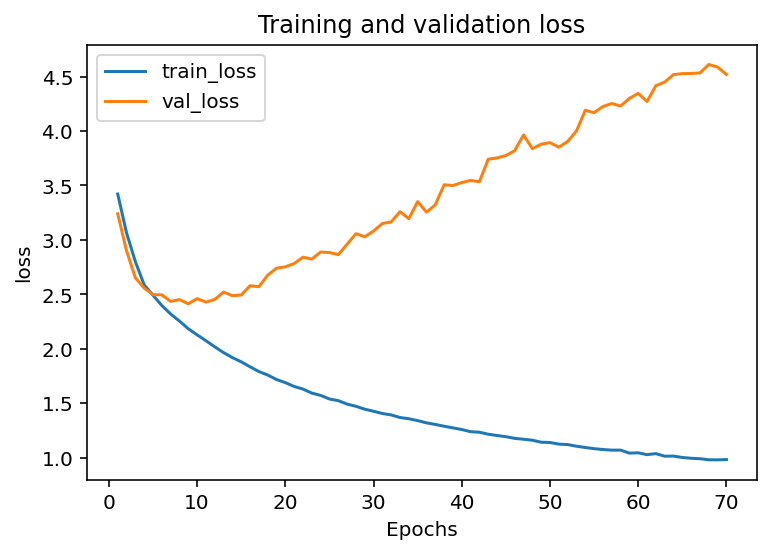

In [161]:
plot_metric(history=deep_nn_history, metric='loss')

In [162]:
score = deep_nn.evaluate(x_test, y_test, verbose=0)
print("Testing Accuracy: {0:.2%}".format(score[1]))

Testing Accuracy: 22.47%


## Bigger NN model 

In [163]:
big_nn = big_nn_model()
big_nn, big_nn_history = fit_model(model=simple_nn, X=X, y=yy,
                                         epochs=70, validation_data=(x_val, y_val), verbose=1)

Epoch 1/70
1597/1597 [==============================] - 3s 2ms/step - loss: 2.6654 - accuracy: 0.2396 - val_loss: 2.6882 - val_accuracy: 0.2402
Epoch 2/70
1597/1597 [==============================] - 3s 2ms/step - loss: 2.6600 - accuracy: 0.2398 - val_loss: 2.6400 - val_accuracy: 0.2487
Epoch 3/70
1597/1597 [==============================] - 5s 3ms/step - loss: 2.6578 - accuracy: 0.2391 - val_loss: 2.6302 - val_accuracy: 0.2502
Epoch 4/70
1597/1597 [==============================] - 3s 2ms/step - loss: 2.6623 - accuracy: 0.2403 - val_loss: 2.6338 - val_accuracy: 0.2436
Epoch 5/70
1597/1597 [==============================] - 3s 2ms/step - loss: 2.6619 - accuracy: 0.2389 - val_loss: 2.5892 - val_accuracy: 0.2580
Epoch 6/70
1597/1597 [==============================] - 2s 1ms/step - loss: 2.6643 - accuracy: 0.2404 - val_loss: 2.6363 - val_accuracy: 0.2476
Epoch 7/70
1597/1597 [==============================] - 2s 1ms/step - loss: 2.6606 - accuracy: 0.2387 - val_loss: 2.6378 - val_accuracy:

1597/1597 [==============================] - 2s 1ms/step - loss: 2.6620 - accuracy: 0.2383 - val_loss: 2.6641 - val_accuracy: 0.2234
Epoch 58/70
1597/1597 [==============================] - 2s 1ms/step - loss: 2.6622 - accuracy: 0.2393 - val_loss: 2.6258 - val_accuracy: 0.2514
Epoch 59/70
1597/1597 [==============================] - 2s 1ms/step - loss: 2.6572 - accuracy: 0.2406 - val_loss: 2.7538 - val_accuracy: 0.2223
Epoch 60/70
1597/1597 [==============================] - 2s 1ms/step - loss: 2.6566 - accuracy: 0.2387 - val_loss: 2.6496 - val_accuracy: 0.2399
Epoch 61/70
1597/1597 [==============================] - 2s 1ms/step - loss: 2.6623 - accuracy: 0.2386 - val_loss: 2.6597 - val_accuracy: 0.2407
Epoch 62/70
1597/1597 [==============================] - 2s 1ms/step - loss: 2.6546 - accuracy: 0.2433 - val_loss: 2.5732 - val_accuracy: 0.2623
Epoch 63/70
1597/1597 [==============================] - 2s 1ms/step - loss: 2.6616 - accuracy: 0.2379 - val_loss: 2.6566 - val_accuracy: 0.25

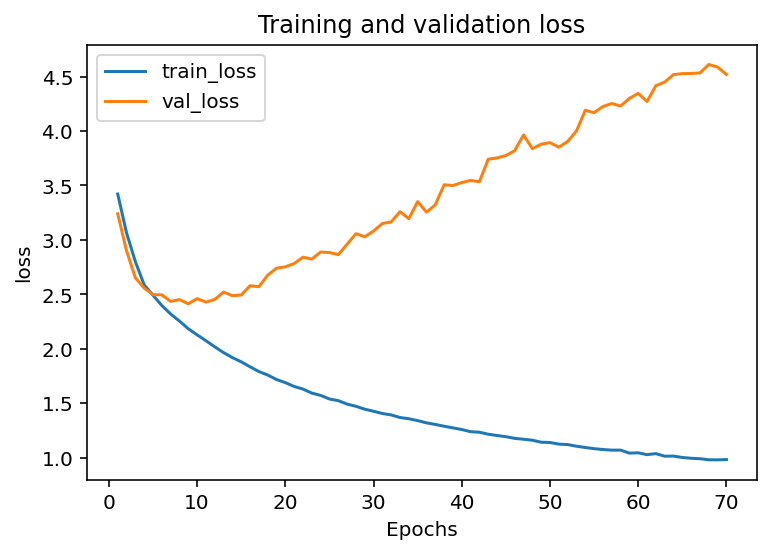

In [164]:
plot_metric(history=big_nn_history, metric='loss')

In [165]:
score = big_nn.evaluate(x_test, y_test, verbose=0)
print("Testing Accuracy: {0:.2%}".format(score[1]))

Testing Accuracy: 21.99%


In [166]:
y_deep_nn_pred = deep_nn.predict(x_test)
y_big_nn_pred = big_nn.predict(x_test)

In [167]:
(y_deep_nn_pred[0]).round(2)

array([28.71, 30.73, 34.57, 34.06, 32.98, 22.03, 35.29, 33.85, 31.  ,
       29.54, 35.19, 32.3 , 30.41, 29.04, 30.31, 36.38, 33.33, 30.97,
       31.84, 30.85, 25.9 , 27.74, 35.24, 24.27, 21.87, 26.72, 34.46,
       35.67, 26.47, 28.93], dtype=float32)

In [168]:
y_test[0]

array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)